# Supervised GloVe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import os, sys, time
from importlib import reload
%matplotlib inline

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda, Add
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import get_frequency, preprocess

from ccs_tools import dx_multi, pr_multi, core_dtypes_pd, dx_label

Using TensorFlow backend.


## Data Preparation

In [176]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(n) for n in range(2, n_DX+2)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]
Others = ['AGE', 'FEMALE']

In [177]:
cohort='ami'
folder = 'multi_space_glove/'
tst_seed=0

In [214]:
all_df = pd.read_csv(path+folder+'cohorts10/{}/pred_comorb.csv'.format(cohort), dtype=core_dtypes_pd)

In [215]:
DX1_rarecutpoint = 10
DX_rarecutpoint = 10
PR_rarecutpoint = 10

In [216]:
preprocessed = preprocess(all_df, DX_rarecutpoint=DX_rarecutpoint, PR_rarecutpoint=PR_rarecutpoint)
all_df = preprocessed['int_df']

tst_key = pd.read_csv(path+folder+'cohorts10/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index(drop=True)
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index(drop=True)

DX1_cat = preprocessed['DX1_cat']
DX_cat = preprocessed['DX_cat']
PR_cat = preprocessed['PR_cat']
DX1_dict = preprocessed['DX1_dict']
DX_dict = preprocessed['DX_dict']
PR_dict = preprocessed['PR_dict']
code_cat = preprocessed['code_cat']
hosp_cat = preprocessed['hosp_cat']

In [217]:
train_df0.shape, tst_df.shape

((181319, 182), (20719, 182))

### Collect Co-occurence Counts by Glove class

In [12]:
from glove import Glove

In [14]:
code_embed_dim=100
count_cap=20

In [15]:
g = Glove(input_dim=len(preprocessed['code_cat']), embedding_dim=code_embed_dim, count_cap=count_cap)

In [16]:
g.update_cooccur(train_df0[['DX1']+DXs+PRs])

Updating co-occurrence matrix from a Dataframe with 181319 rows...
Finished. It takes 31.0 seconds to update the cooccurrences.


In [17]:
cooccur_df = g.get_cooccur_df()

In [18]:
cooccur_df.shape

(896850, 3)

In [19]:
parent_pairs = preprocessed['parent_pairs']

### Data formating

In [184]:
DX1_cat = preprocessed['DX1_cat']
DX_cat = preprocessed['DX_cat']
PR_cat = preprocessed['PR_cat']
DX1_dict = preprocessed['DX1_dict']
DX_dict = preprocessed['DX_dict']
PR_dict = preprocessed['PR_dict']
code_cat = preprocessed['code_cat']
hosp_cat = preprocessed['hosp_cat']

In [21]:
train_df = train_df0.copy()

In [22]:
n_fold = 5

In [23]:
skf = StratifiedKFold(n_splits=n_fold, random_state=24, shuffle=True)

In [24]:
trn_idx, val_idx = next(skf.split(train_df, train_df0.HOSP_NRD))

In [170]:
trn_df = train_df.loc[trn_idx].reset_index(drop=True)
val_df = train_df.loc[val_idx].reset_index(drop=True)

### Data Generator

In [33]:
from keras.utils import Sequence

In [193]:
batchsize_ratio = 4

In [194]:
class DoubleBatchGenerator(Sequence):
    'Generates data from two datasets'
    def __init__(self, cooccur_df, readm_df, readm_batchsize=512, batchsize_ratio=4, shuffle=True, scaling_factor=0.75, 
                count_cap=20):
        '''Initialization
        Here coocur_df and readm_df need to have integer index from 0, i.e. they need to reset_index()'''
        self.readm_batchsize = readm_batchsize
        self.cooccur_batchsize = readm_batchsize*batchsize_ratio
        self.batchsize_ratio = batchsize_ratio
        self.cooccur_df = cooccur_df
        self.readm_df = readm_df
        self.shuffle = shuffle
        self.__scaling_factor = scaling_factor
        self.__count_cap = count_cap
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        readm_steps = np.floor(len(self.readm_df) / self.readm_batchsize)
        cooccur_steps = np.floor(len(self.cooccur_df)/self.cooccur_batchsize)
        return int(np.min((readm_steps, cooccur_steps)))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        readm_indexes = self.readm_indexes[index*self.readm_batchsize:(index+1)*self.readm_batchsize]
        cooccur_indexes = self.cooccur_indexes[index*self.cooccur_batchsize:(index+1)*self.cooccur_batchsize]

        DX1_array = self.readm_df.loc[readm_indexes, 'DX1'].values
        DX_mat = self.readm_df.loc[readm_indexes, DXs].values
        PR_mat = self.readm_df.loc[readm_indexes, PRs].values
        hosp_array = self.readm_df.loc[readm_indexes, 'HOSP_NRD'].values
        other_mat = self.readm_df.loc[readm_indexes, Others].values
        y_readm = self.readm_df.loc[readm_indexes, 'readm30'].astype(int).values
        Y_readm = to_categorical(y_readm, num_classes=2)

        focal_id = self.cooccur_df.loc[cooccur_indexes, 'focal_index'].values
        context_id = self.cooccur_df.loc[cooccur_indexes, 'context_index'].values
        y_cooccur = np.log(self.cooccur_df.loc[cooccur_indexes, 'cooccur_counts'].values)
        
        focal_id = np.reshape(focal_id, (self.readm_batchsize, self.batchsize_ratio))
        context_id = np.reshape(context_id, (self.readm_batchsize, self.batchsize_ratio))
        y_cooccur = np.reshape(y_cooccur, (self.readm_batchsize, self.batchsize_ratio))

        return [DX1_array, DX_mat, PR_mat, hosp_array, other_mat, focal_id, context_id], [Y_readm, y_cooccur]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.readm_indexes = np.arange(len(self.readm_df))
        self.cooccur_indexes = np.arange(len(self.cooccur_df))
        if self.shuffle == True:
            np.random.shuffle(self.readm_indexes)
            np.random.shuffle(self.cooccur_indexes)

In [195]:
count_cap = 20
scaling_factor = 0.75
def weighting_factor(count):
    ge_mask = K.cast(K.greater_equal(count, count_cap), K.floatx())
    l_mask = K.cast(K.less(count, count_cap), K.floatx())
    return 1.*ge_mask + np.power(count/count_cap, scaling_factor)*l_mask

In [196]:
def loss_cooccur(y_true, y_pred):
    weight_cooccur = weighting_factor(K.exp(y_true))
    return K.mean(K.square(y_pred - y_true)*weight_cooccur)

In [208]:
trn_gen = DoubleBatchGenerator(cooccur_df=cooccur_df, readm_df=trn_df, readm_batchsize=256, batchsize_ratio=batchsize_ratio, 
                               shuffle=True)

In [209]:
val_gen = DoubleBatchGenerator(cooccur_df=cooccur_df, readm_df=val_df, readm_batchsize=256, batchsize_ratio=batchsize_ratio, 
                               shuffle=False)

In [218]:
tst_gen = DoubleBatchGenerator(cooccur_df=cooccur_df, readm_df=tst_df, readm_batchsize=256, batchsize_ratio=batchsize_ratio, 
                               shuffle=False)

In [206]:
len(trn_df)/512, len(val_df)/512, len(cooccur_df)/512/batchsize_ratio

(282.447265625, 71.69140625, 437.9150390625)

In [167]:
arrays = next(iter(trn_gen))

In [168]:
arrays

([array([12, 16, 16, 16]),
  array([[2404,  528,  357,  844,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0],
         [ 844,    0,    0,  241,  790, 2409, 2361, 2364, 1836,  357,  313,
          1267,  348,  388,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0],
         [1482,  801,  313,  233, 1434,  844,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0],
         [ 924,  790,    0,  562, 2280, 1199,  299, 1159, 1819,  313,  856,
          2192,  922, 1107,  785,    0,  929, 2361,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0]]),
  array([[2426, 2422, 2428, 2502, 2722, 2438, 2520,    0,    0,    0,    0,
             0,    0,    0,    0],
         [2590, 2714, 2722, 2520, 2588, 

In [169]:
cooccur_df.head(8)

,focal_index,context_index,cooccur_counts
0,1481,928,1.0
1,2139,1409,11.0
2,1898,1602,1.0
3,312,241,427.0
4,2423,1213,1.0
5,1688,781,9.0
6,2745,993,9.0
7,2466,1218,1.0


### Model Building

In [71]:
from setsum_layer import SetSum, MaskedSum, MaskedDense, MaskedPooling
from keras.layers import Multiply

In [30]:
from keras_multi_head import MultiHeadAttention

In [200]:
code_embed_dim = 100
md_width = 64
fc_width = 512
hosp_embed_dim = 1
dropout = 0.3
job_index = 0
batchsize = 512
parent_pairs = None

In [96]:
embed_initializer = Constant(embed_mat)

NameError: name 'embed_mat' is not defined

In [201]:
embed_initializer = 'uniform'

In [202]:
input_w = Input(shape=(batchsize_ratio,), name='focal_index')
input_v = Input(shape=(batchsize_ratio,), name='context_index')
if parent_pairs is None:
    embed_layer = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, name='embed')
else:
    embed_layer = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, name='embed',
                            embeddings_regularizer=Parent_reg(parent_pairs, lamb, metric))
w_embed = embed_layer(input_w)
v_embed = embed_layer(input_v)
bias_layer = Embedding(input_dim=len(code_cat), output_dim=1, name='bias')
w_bias = bias_layer(input_w)
v_bias = bias_layer(input_v)

inner = Multiply()([w_embed, v_embed])
inner = Lambda(lambda x: K.sum(x, axis=-1, keepdims=True))(inner)

merged = Concatenate(axis=-1)([inner, w_bias, v_bias])

output_cooccur = Lambda(lambda x: K.sum(x, axis=-1, keepdims=False), name='cooccur')(merged)

input_DX1 = Input(shape=(1,))
DX1_embed = embed_layer(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)
input_DX = Input(shape = (len(DXs),))
DX_embed = embed_layer(input_DX)
DX_embed = MaskedDense(md_width, activation='relu')(DX_embed)
DX_embed = MaskedSum()(DX_embed)
input_PR = Input(shape = (len(PRs),))
PR_embed = embed_layer(input_PR)
PR_embed = MaskedDense(md_width, activation='relu')(PR_embed)
PR_embed = MaskedSum()(PR_embed)
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat_train.shape[1], ))
merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, hosp_embed, input_other])
merged = Dense(fc_width, activation='relu')(merged)
merged = Dropout(dropout)(merged)
output_readm = Dense(2, activation='softmax', name='readm')(merged)

model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other, input_w, input_v], 
              outputs=[output_readm, output_cooccur])

In [203]:
adam = Adam(lr=5e-4)
model.compile(loss={'readm':'categorical_crossentropy', 'cooccur':loss_cooccur}, 
             optimizer=adam, 
             loss_weights={'readm':1., 'cooccur':1.})

In [532]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'embeding_nn_temp'+str(job_index)+'.h5', validation_y=Y_val[:, 1], 
                                 validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [454]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [211]:
hist = model.fit_generator(generator=trn_gen, validation_data=val_gen, epochs=20, verbose=1)

Epoch 1/20
564/564 [==============================] - 17s 31ms/step - loss: 2.8996 - readm_loss: 0.3487 - cooccur_loss: 2.5510 - val_loss: 2.9153 - val_readm_loss: 0.3452 - val_cooccur_loss: 2.5702
Epoch 2/20
564/564 [==============================] - 17s 30ms/step - loss: 2.6290 - readm_loss: 0.3416 - cooccur_loss: 2.2875 - val_loss: 2.4299 - val_readm_loss: 0.3427 - val_cooccur_loss: 2.0873
Epoch 3/20
564/564 [==============================] - 17s 30ms/step - loss: 1.7837 - readm_loss: 0.3387 - cooccur_loss: 1.4450 - val_loss: 1.1876 - val_readm_loss: 0.3424 - val_cooccur_loss: 0.8451
Epoch 4/20
564/564 [==============================] - 20s 35ms/step - loss: 0.7943 - readm_loss: 0.3374 - cooccur_loss: 0.4569 - val_loss: 0.6045 - val_readm_loss: 0.3434 - val_cooccur_loss: 0.2611
Epoch 5/20
564/564 [==============================] - 20s 35ms/step - loss: 0.5373 - readm_loss: 0.3357 - cooccur_loss: 0.2016 - val_loss: 0.5123 - val_readm_loss: 0.3421 - val_cooccur_loss: 0.1702
Epoch 6/20

In [533]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], Y_trn, 
                     batch_size=batchsize, epochs=30, callbacks=[auccheckpoint, reduce_lr, earlystop], 
                     validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], Y_val], 
                    verbose=1)

Train on 62090 samples, validate on 15976 samples
Epoch 1/30
62090/62090 [==============================] - 6s 104us/step - loss: 0.3077 - val_loss: 0.3170
AUC: 0.7102

Epoch 2/30
62090/62090 [==============================] - 2s 25us/step - loss: 0.3075 - val_loss: 0.3171
AUC: 0.7104

Epoch 3/30
62090/62090 [==============================] - 1s 23us/step - loss: 0.3072 - val_loss: 0.3171
AUC: 0.7105

Epoch 4/30
62090/62090 [==============================] - 1s 24us/step - loss: 0.3070 - val_loss: 0.3172
AUC: 0.7103

Epoch 5/30
62090/62090 [==============================] - 1s 24us/step - loss: 0.3063 - val_loss: 0.3171
AUC: 0.7104

Epoch 6/30
62090/62090 [==============================] - 1s 23us/step - loss: 0.3060 - val_loss: 0.3171
AUC: 0.7107

Epoch 7/30
62090/62090 [==============================] - 1s 24us/step - loss: 0.3056 - val_loss: 0.3172
AUC: 0.7106

Epoch 8/30
62090/62090 [==============================] - 1s 23us/step - loss: 0.3055 - val_loss: 0.3172
AUC: 0.7106

Epoch

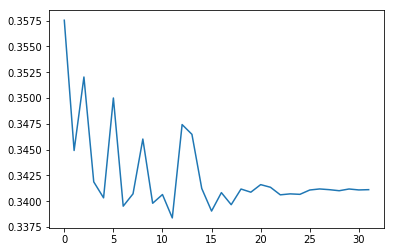

In [105]:
plt.plot(hist.history['val_loss'])

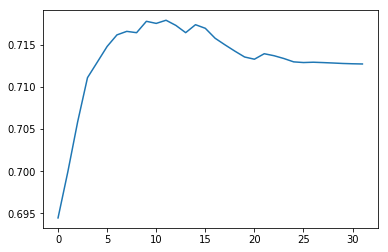

In [106]:
plt.plot(auccheckpoint.auc_history)

In [534]:
model.load_weights(model_path+'embeding_nn_temp'+str(job_index)+'.h5')

In [219]:
y = model.predict_generator(tst_gen, verbose=1)

80/80 [==============================] - 1s 16ms/step


In [220]:
y[0]

[array([[0.7344694 , 0.26553062],
        [0.9152254 , 0.08477461],
        [0.8734931 , 0.12650691],
        ...,
        [0.74305004, 0.25694996],
        [0.7577038 , 0.2422963 ],
        [0.6693048 , 0.33069518]], dtype=float32),
 array([[0.41521823, 2.5294583 , 0.9428971 , 5.565948  ],
        [0.6144388 , 2.202258  , 2.1306427 , 0.1867327 ],
        [0.7124145 , 0.9411886 , 0.6416438 , 0.10872786],
        ...,
        [2.2309911 , 0.5028403 , 0.4565217 , 1.4713295 ],
        [4.421336  , 0.71095407, 0.3599179 , 1.6731604 ],
        [4.9626756 , 0.53126544, 1.0251919 , 0.5296705 ]], dtype=float32)]

In [227]:
y_pred = y[0][:, 1]
y_true = tst_df.readm30.astype(int).values[:len(y_pred)]

{0: 0.689598222510154}

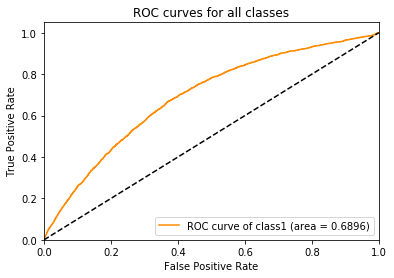

In [231]:
plot_roc(y_pred, y_true)